In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import itertools
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img,img_to_array

from keras.utils import np_utils
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Reshape, Dropout
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

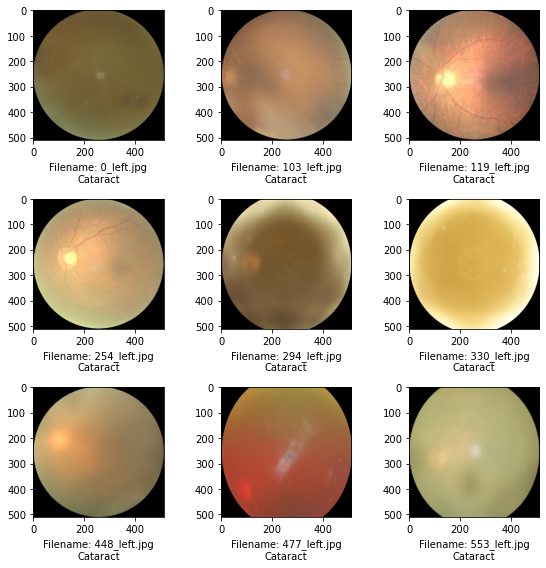

In [2]:
# for VGG pre-trained model it only accepts a 224 x 224 image size
img_size = 224

#======Understanding the dataset=====================================#
df_data = pd.read_csv(r"D:\kaggle\input\ocular-disease-recognition-odir5k\full_df.csv")
#df_data.head()
#df_data[df_data.C==1].head()
#df_data.info()
#df_data[df_data == 1].sum(axis=0)
df_data2 = df_data.iloc[:, 1:7]
#df_data2['filepath'] = pd.Series(df_data['filepath'])
#df_data2.head()
img_dir = r"D:\kaggle\input\ocular-disease-recognition-odir5k\preprocessed_images"
df_data2[df_data2['Left-Diagnostic Keywords'].str.match('cataract')].head()
df_left_cat = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('cataract')]
#print(len(df_left_cat))
df_data[df_data['Right-Diagnostic Keywords'].str.match('cataract')].head()
df_rt_cat = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('cataract')]
#print(len(df_rt_cat))
df_cat_filenames = df_left_cat['Left-Fundus'].append(df_rt_cat['Right-Fundus'], ignore_index=True)
df_cat_filenames.head()
df_cat_filenames.tail()
len(df_cat_filenames)

df_left_norm = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('normal')]
#print(len(df_left_norm))
df_rt_norm = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('normal')]
#print(len(df_rt_norm))

df_norm_filenames = df_left_norm['Left-Fundus'].append(df_rt_norm['Right-Fundus'], ignore_index=True)
#print(df_norm_filenames)

df_norm_filenames_random = df_norm_filenames.sample(n = 572)
#print(df_norm_filenames_random.head())

df_norm_filenames_random = df_norm_filenames_random.reset_index(drop=True)
#print(df_norm_filenames_random)

img = df_cat_filenames[342]
image = cv2.imread(os.path.join(img_dir, img))
#plt.imshow(image)
#print(image.shape)
#print(img)



plt.figure(figsize=(8,8))
for i in range(9):
    img = df_cat_filenames[i]
    image = cv2.imread(os.path.join(img_dir, img))

    # convert image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # subplot variables - (iterating through locations on grid)
    plt.subplot(3,3,i+1)
    plt.imshow(image_rgb)
    
    # label with filename and diagnosis
    plt.xlabel('Filename: {}\n''Cataract'.format(df_cat_filenames[i]))

plt.tight_layout() 





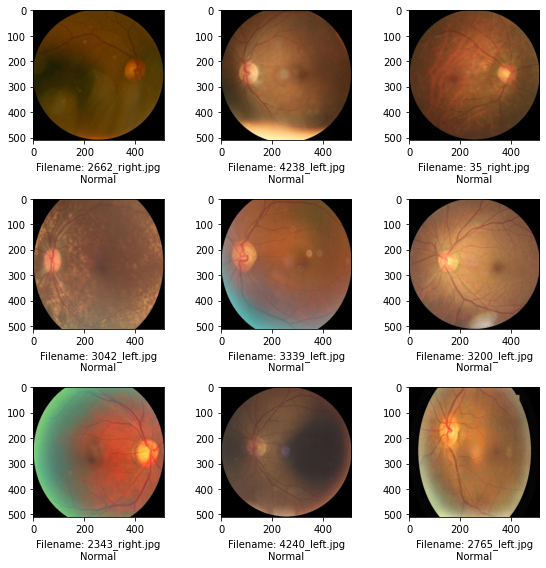

In [3]:
plt.figure(figsize=(8,8))
for i in range(9):
    img = df_norm_filenames_random[i]
    image = cv2.imread(os.path.join(img_dir, img))

    # convert image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # subplot variables - (iterating through locations on grid)
    plt.subplot(3,3,i+1)
    plt.imshow(image_rgb)
    
    # label with filename and diagnosis
    plt.xlabel('Filename: {}\n''Normal'.format(df_norm_filenames_random[i]))

plt.tight_layout() 

In [5]:
df_cat_filenames = pd.DataFrame(df_cat_filenames, columns = ["filename"])
#df_cat_filenames.set_index("filename", inplace = True)

# add a new column of '1' to the dataframe
df_cat_filenames["label"] = "cataract"

#print(df_cat_filenames.head())

df_norm_filenames_random = pd.DataFrame(df_norm_filenames_random, columns = ["filename"])
#df_cat_filenames.set_index("filename", inplace = True)

# add a new column of '1' to the dataframe
df_norm_filenames_random["label"] = "normal"

#print(df_norm_filenames_random.head())

df_combined = df_cat_filenames.append(df_norm_filenames_random, ignore_index=True)
#df_combined

df_combined_random = df_combined.sample(frac=1).reset_index(drop=True)
df_combined_random

# pull 80% of the combined dataset and reserve it for the training data
# the data generator will automatically create a validation set for us later

df_train = df_combined_random.sample(frac=0.8,random_state=42)
df_train.reset_index(drop=True)

# exclude the 80% that was already chosen, the remaining 20% will go into testing
df_test = df_combined_random.drop(df_train.index)
df_test.reset_index(drop=True)

#print(len(df_combined_random))
#print(len(df_train))
#print(len(df_test))

,filename,label
0,2126_right.jpg,cataract
1,3266_right.jpg,normal
2,2095_right.jpg,cataract
3,2365_left.jpg,normal
4,183_right.jpg,normal
...,...,...
224,1054_right.jpg,normal
225,2155_right.jpg,cataract
226,2361_left.jpg,normal
227,3188_right.jpg,normal


In [6]:
train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255.,
            validation_split=0.20,
            rotation_range=90,
#            width_shift_range=0.2,
#            height_shift_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            shear_range=0.2,
            brightness_range=[0.3,1]    
#            zoom_range=0.2
            )

#for testing I don't want to do too much augmentation, I'll just scale it.

test_datagen=ImageDataGenerator(rescale=1./255.)

df_train['label'] = df_train['label'].astype(str)
df_test['label'] = df_test['label'].astype(str)


train_generator=train_datagen.flow_from_dataframe(
dataframe=df_train,
directory=img_dir,
x_col="filename",
y_col="label",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(img_size,img_size))

# validation set is created from the training set, 
# we set it at 20% of the training data in the previous code

valid_generator=train_datagen.flow_from_dataframe(
dataframe=df_train,
directory=img_dir,
x_col="filename",
y_col="label",
subset="validation",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(img_size,img_size))


test_generator=test_datagen.flow_from_dataframe(
dataframe=df_test,
directory=img_dir,
x_col="filename",
y_col="label",
batch_size=32,
#seed=42,
shuffle=False,
class_mode="categorical",
target_size=(img_size,img_size))

Found 732 validated image filenames belonging to 2 classes.
Found 183 validated image filenames belonging to 2 classes.
Found 229 validated image filenames belonging to 2 classes.


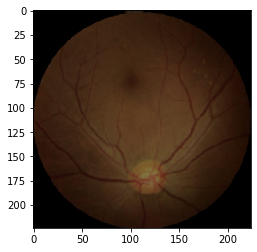

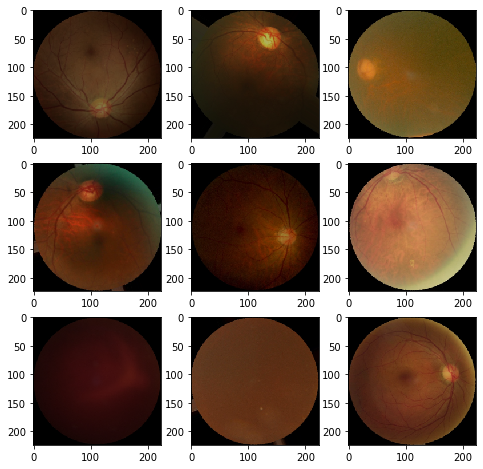

In [7]:
train_image_data, train_labels = train_generator.next()
#train_image_data[0]
train_image_data.shape

train_labels[0]

plt.imshow(train_image_data[0], interpolation='nearest')
plt.show()

plt.figure(figsize=(8,8))

for i in range(9):
    plt.subplot(3, 3, i + 1) 
    plt.imshow(train_image_data[i], interpolation='nearest')
    
plt.show() 

In [10]:

vgg16 = keras.applications.vgg16.VGG16(input_shape=(224, 224, 3),
                                       weights='imagenet',
                                       include_top=False)

# add new dense layers at the top
x = keras.layers.Flatten()(vgg16.output)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128, activation='relu')(x)

## i'm using just 2 outputs only
predictions = keras.layers.Dense(2, activation='softmax')(x)

# define and compile model
model = keras.Model(inputs=vgg16.inputs, outputs=predictions)
for layer in vgg16.layers:
    layer.trainable = False
    
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [11]:
checkpoint = ModelCheckpoint("vgg16_1.h5", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto', 
                             period=1)

early = EarlyStopping(monitor='val_accuracy', 
                      min_delta=0, 
                      patience=3, 
                      verbose=1, 
                      mode='auto')

In [ ]:
batch_size = 32
n_spe = train_generator.samples // batch_size
n_val_steps = valid_generator.samples // batch_size
n_epochs = 30

#print(n_spe,n_val_steps)

hist = model.fit(train_generator,
                        steps_per_epoch=n_spe,
                        validation_data=valid_generator,
                        validation_steps=n_val_steps,
                        epochs=n_epochs,
                        shuffle=True,
                        workers=5,
                        use_multiprocessing=True,
                        callbacks=[checkpoint,early])

Epoch 1/30


Exception in thread Thread-7:
Traceback (most recent call last):
  File "c:\users\hp\appdata\local\programs\python\python38\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "c:\users\hp\appdata\local\programs\python\python38\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "c:\users\hp\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\utils\data_utils.py", line 727, in _run
    with closing(self.executor_fn(_SHARED_SEQUENCES)) as executor:
  File "c:\users\hp\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\utils\data_utils.py", line 704, in pool_fn
    pool = get_pool_class(True)(
  File "c:\users\hp\appdata\local\programs\python\python38\lib\multiprocessing\context.py", line 119, in Pool
    return Pool(processes, initializer, initargs, maxtasksperchild,
  File "c:\users\hp\appdata\local\programs\python\python38\lib\multiprocessing\pool.py", line 212, in __init